In [15]:
# cluster_crossmatch_vectorized.ipynb

import numpy as np
import h5py
from astropy.cosmology import Planck18, z_at_value
import astropy.units as u
import pandas as pd
from pymanticore.cosmology import ra_dec_to_galactic
import time
from pymanticore.analysis.matplotlib import get_mplstyle_path, ManticoreColors


# Matching parameters
ANGULAR_SEP_TOLERANCE_DEG = 0.5  # degrees
REDSHIFT_TOLERANCE = 0.005

def vectorized_angular_separation_deg(lon1, lat1, lon2, lat2):
    """Vectorized angular separation calculation using Haversine formula"""
    # Convert to radians separately
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)
    
    # Broadcast to create matrices
    lon1 = lon1[:, np.newaxis]  # Shape: [N_manticore, 1]
    lat1 = lat1[:, np.newaxis]  # Shape: [N_manticore, 1] 
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return np.degrees(c)  # Shape: [N_manticore, N_external]

# First, we need to update the matching function to return matched indices
def vectorized_find_matches_with_indices(manticore_data, external_data, ang_tol_deg, z_tol):
    """Enhanced version that also returns matched external cluster indices"""
    
    # Calculate all pairwise angular separations
    ang_seps = vectorized_angular_separation_deg(
        manticore_data['gal_l'], manticore_data['gal_b'],
        external_data['gal_l'], external_data['gal_b']
    )
    
    # Calculate all pairwise redshift differences
    manticore_z = manticore_data['z'][:, np.newaxis]
    external_z = external_data['z']
    z_diffs = np.abs(external_z - manticore_z)
    
    # Apply matching criteria
    valid_matches = (ang_seps <= ang_tol_deg) & (z_diffs <= z_tol)
    
    # For each Manticore cluster, find the closest angular match among valid ones
    ang_seps_masked = np.where(valid_matches, ang_seps, np.inf)
    
    # Find best match index for each Manticore cluster
    best_match_indices = np.argmin(ang_seps_masked, axis=1)
    
    # Check if there were any valid matches
    has_match = np.any(valid_matches, axis=1)
    
    # Extract results
    n_manticore = len(manticore_data['gal_l'])
    
    matched_m500 = np.full(n_manticore, np.nan)
    matched_ang_sep = np.full(n_manticore, np.nan)
    matched_z_diff = np.full(n_manticore, np.nan)
    matched_indices = np.full(n_manticore, -1, dtype=int)  # -1 for no match
    
    # Only fill in for clusters that have matches
    if np.any(has_match):
        valid_indices = np.where(has_match)[0]
        match_indices = best_match_indices[has_match]
        
        matched_m500[valid_indices] = external_data['m500'][match_indices]
        matched_ang_sep[valid_indices] = ang_seps[valid_indices, match_indices]
        matched_z_diff[valid_indices] = z_diffs[valid_indices, match_indices]
        matched_indices[valid_indices] = match_indices
    
    return matched_m500, matched_ang_sep, matched_z_diff, has_match, matched_indices


# Load cluster data

In [2]:
# Load Manticore posterior clusters
print("Loading Manticore clusters...")
fname = "/cosma7/data/dp004/rttw52/Manticore/new_analysis/clusters/temp/output/simplified_clusters.h5"

with h5py.File(fname, "r") as f:
    distances_mpc = f["clusters/median_properties/dist"][...]
    
    redshifts = []
    for dist in distances_mpc:
        z = z_at_value(Planck18.comoving_distance, dist * u.Mpc)
        redshifts.append(z)
    
    manticore_data = {
        "gal_l": f["clusters/median_properties/gal_l"][...],
        "gal_b": f["clusters/median_properties/gal_b"][...],
        "m500": f["clusters/median_properties/SO_500_crit_TotalMass"][...],
        "m500_p25": f["clusters/mass_uncertainties/p25/SO_500_crit_TotalMass"][...],
        "m500_p75": f["clusters/mass_uncertainties/p75/SO_500_crit_TotalMass"][...],
        "r500": f["clusters/median_properties/SO_500_crit_SORadius"][...],
        "dist": distances_mpc,
        "z": np.array(redshifts),
        "ra": f["clusters/median_properties/ra"][...],
        "dec": f["clusters/median_properties/dec"][...],
        "coords": f["clusters/median_properties/BoundSubhalo_CentreOfMass"][...],
    }

print(f"Loaded {len(manticore_data['gal_l'])} Manticore clusters")

Loading Manticore clusters...
Loaded 225 Manticore clusters


In [3]:
# Load MCXC cluster catalog
print("Loading MCXC clusters...")
fname = "/cosma7/data/dp004/rttw52/Manticore/observational_data/mcxc_2_clusters/mcxc_clusters.hdf5"

with h5py.File(fname, "r") as f:
    _mcxc_data = f["all_clusters"][...]

_ra = np.degrees(_mcxc_data["phi"])
_dec = np.degrees(_mcxc_data["theta"])
gal_l, gal_b = ra_dec_to_galactic(_ra, _dec)

mcxc_data = {
    "name": _mcxc_data["name"],
    "mcxc_name": _mcxc_data["mcxc_name"],
    "gal_l": gal_l, 
    "gal_b": gal_b, 
    "z": _mcxc_data["z"], 
    "m500": _mcxc_data["M500"]*1e14, 
    "r500": _mcxc_data["R500"]
}

print(f"Loaded {len(mcxc_data['gal_l'])} MCXC clusters")

Loading MCXC clusters...
Loaded 2221 MCXC clusters


In [4]:
# Load eROSITA cluster catalog
print("Loading eROSITA clusters...")
fname = "/cosma7/data/dp004/rttw52/Manticore/observational_data/erosita_clusters/erosita_clusters.hdf5"

with h5py.File(fname, "r") as f:
    _eros_data = f["all_clusters"][...]

_ra = np.degrees(_eros_data["phi"])
_dec = np.degrees(_eros_data["theta"])
gal_l, gal_b = ra_dec_to_galactic(_ra, _dec)

eros_data = {
    "gal_l": gal_l, 
    "gal_b": gal_b, 
    "z": _eros_data["z"], 
    "m500": _eros_data["M500"]*1e14, 
    "r500": _eros_data["R500"]
}

print(f"Loaded {len(eros_data['gal_l'])} eROSITA clusters")

Loading eROSITA clusters...
Loaded 12247 eROSITA clusters


# Perform cross matching

In [5]:
# Perform vectorized cross-matching
print("Cross-matching Manticore clusters with external catalogs...")
start_time = time.time()

# Match with MCXC
mcxc_m500, mcxc_ang_sep, mcxc_z_diff, mcxc_matched, _ = vectorized_find_matches_with_indices(
    manticore_data, mcxc_data, ANGULAR_SEP_TOLERANCE_DEG, REDSHIFT_TOLERANCE
)

# Match with eROSITA  
eros_m500, eros_ang_sep, eros_z_diff, eros_matched, _ = vectorized_find_matches_with_indices(
    manticore_data, eros_data, ANGULAR_SEP_TOLERANCE_DEG, REDSHIFT_TOLERANCE
)

end_time = time.time()
print(f"Matching completed in {end_time - start_time:.3f} seconds")

n_manticore = len(manticore_data['gal_l'])
print(f"MCXC matches: {np.sum(mcxc_matched)}/{n_manticore}")
print(f"eROSITA matches: {np.sum(eros_matched)}/{n_manticore}")
print(f"Both catalogs: {np.sum(mcxc_matched & eros_matched)}")

Cross-matching Manticore clusters with external catalogs...
Matching completed in 0.260 seconds
MCXC matches: 85/225
eROSITA matches: 65/225
Both catalogs: 45


In [6]:
# Create enhanced Manticore dataset with external matches
enhanced_manticore = {
    # Original Manticore data
    "gal_l": manticore_data["gal_l"],
    "gal_b": manticore_data["gal_b"],
    "z": manticore_data["z"],
    "m500_manticore": manticore_data["m500"],
    "m500_manticore_p25": manticore_data["m500_p25"],
    "m500_manticore_p75": manticore_data["m500_p75"],
    "r500": manticore_data["r500"],
    "ra": manticore_data["ra"],
    "dec": manticore_data["dec"],
    
    # MCXC matches
    "m500_mcxc": mcxc_m500,
    "mcxc_ang_sep": mcxc_ang_sep,
    "mcxc_z_diff": mcxc_z_diff,
    "mcxc_matched": mcxc_matched,
    
    # eROSITA matches
    "m500_erosita": eros_m500,
    "eros_ang_sep": eros_ang_sep,
    "eros_z_diff": eros_z_diff,
    "eros_matched": eros_matched
}

print("\nEnhanced Manticore dataset created with external catalog matches")
print(f"Total clusters: {len(enhanced_manticore['gal_l'])}")
print(f"With MCXC counterparts: {np.sum(enhanced_manticore['mcxc_matched'])}")
print(f"With eROSITA counterparts: {np.sum(enhanced_manticore['eros_matched'])}")


Enhanced Manticore dataset created with external catalog matches
Total clusters: 225
With MCXC counterparts: 85
With eROSITA counterparts: 65


In [ ]:
# Summary statistics
print(f"\nMatching Statistics (tolerance: {ANGULAR_SEP_TOLERANCE_DEG}° angular, Δz={REDSHIFT_TOLERANCE})")
print("="*70)

mcxc_matches = np.sum(enhanced_manticore['mcxc_matched'])
eros_matches = np.sum(enhanced_manticore['eros_matched'])
both_matches = np.sum(enhanced_manticore['mcxc_matched'] & enhanced_manticore['eros_matched'])
any_matches = np.sum(enhanced_manticore['mcxc_matched'] | enhanced_manticore['eros_matched'])

print(f"MCXC matches:     {mcxc_matches:4d} ({100*mcxc_matches/n_manticore:.1f}%)")
print(f"eROSITA matches:  {eros_matches:4d} ({100*eros_matches/n_manticore:.1f}%)")
print(f"Both catalogs:    {both_matches:4d} ({100*both_matches/n_manticore:.1f}%)")
print(f"Either catalog:   {any_matches:4d} ({100*any_matches/n_manticore:.1f}%)")
print(f"No matches:       {n_manticore-any_matches:4d} ({100*(n_manticore-any_matches)/n_manticore:.1f}%)")

if mcxc_matches > 0:
    print(f"\nMCXC match quality:")
    print(f"  Median angular sep: {np.nanmedian(enhanced_manticore['mcxc_ang_sep']):.4f}°")
    print(f"  Median redshift diff: {np.nanmedian(enhanced_manticore['mcxc_z_diff']):.4f}")

if eros_matches > 0:
    print(f"\neROSITA match quality:")
    print(f"  Median angular sep: {np.nanmedian(enhanced_manticore['eros_ang_sep']):.4f}°")
    print(f"  Median redshift diff: {np.nanmedian(enhanced_manticore['eros_z_diff']):.4f}")

# Look at some of the best matches

In [45]:
# Re-run matching with enhanced function to get indices
mcxc_m500, mcxc_ang_sep, mcxc_z_diff, mcxc_matched, mcxc_match_indices = vectorized_find_matches_with_indices(
    manticore_data, mcxc_data, ANGULAR_SEP_TOLERANCE_DEG, REDSHIFT_TOLERANCE
)

eros_m500, eros_ang_sep, eros_z_diff, eros_matched, eros_match_indices = vectorized_find_matches_with_indices(
    manticore_data, eros_data, ANGULAR_SEP_TOLERANCE_DEG, REDSHIFT_TOLERANCE
)

print("="*80)
print("TOP 3 MANTICORE CLUSTERS BY MATCH QUALITY")
print("="*80)

# MCXC top matches
print("\n🔵 MCXC MATCHES (top 3 by angular separation)")
print("-"*50)
if np.sum(mcxc_matched) > 0:
    # Get indices of valid matches
    valid_indices = np.where(mcxc_matched)[0]
    valid_ang_seps = mcxc_ang_sep[mcxc_matched]
    
    # Sort by angular separation and get top 3
    sorted_indices = np.argsort(valid_ang_seps)[:3]
    top_mcxc_indices = valid_indices[sorted_indices]
    
    for i, idx in enumerate(top_mcxc_indices):
        mcxc_idx = mcxc_match_indices[idx]
        print(f"\nRank {i+1} - Manticore Cluster #{idx}:")
        print(f"  Position:     RA={manticore_data['ra'][idx]:.4f}°, DEC={manticore_data['dec'][idx]:.4f}°")
        print(f"  Galactic:     l={manticore_data['gal_l'][idx]:.4f}°, b={manticore_data['gal_b'][idx]:.4f}°")
        print(f"  Redshift:     z={manticore_data['z'][idx]:.4f}")
        print(f"  Distance:     {manticore_data['dist'][idx]:.1f} Mpc")
        print(f"  M500:         {manticore_data['m500'][idx]:.2e} M☉")
        print(f"  R500:         {manticore_data['r500'][idx]:.3f} Mpc")
        print(f"  Coords:       {manticore_data['coords'][idx]} Mpc")
        print(f"  Match quality: Δθ={mcxc_ang_sep[idx]:.4f}°, Δz={mcxc_z_diff[idx]:.4f}")
        print(f"  ┌─ MATCHED MCXC CLUSTER:")
        print(f"  │  Name:        {mcxc_data['name'][mcxc_idx]}")
        print(f"  │  Galactic:    l={mcxc_data['gal_l'][mcxc_idx]:.4f}°, b={mcxc_data['gal_b'][mcxc_idx]:.4f}°")
        print(f"  │  Redshift:    z={mcxc_data['z'][mcxc_idx]:.4f}")
        print(f"  └  M500:        {mcxc_data['m500'][mcxc_idx]:.2e} M☉")
else:
    print("No MCXC matches found")

# eROSITA top matches  
print("\n🔴 eROSITA MATCHES (top 3 by angular separation)")
print("-"*50)
if np.sum(eros_matched) > 0:
    # Get indices of valid matches
    valid_indices = np.where(eros_matched)[0]
    valid_ang_seps = eros_ang_sep[eros_matched]
    
    # Sort by angular separation and get top 3
    sorted_indices = np.argsort(valid_ang_seps)[:3]
    top_eros_indices = valid_indices[sorted_indices]
    
    for i, idx in enumerate(top_eros_indices):
        eros_idx = eros_match_indices[idx]
        print(f"\nRank {i+1} - Manticore Cluster #{idx}:")
        print(f"  Position:     RA={manticore_data['ra'][idx]:.4f}°, DEC={manticore_data['dec'][idx]:.4f}°")
        print(f"  Galactic:     l={manticore_data['gal_l'][idx]:.4f}°, b={manticore_data['gal_b'][idx]:.4f}°")
        print(f"  Redshift:     z={manticore_data['z'][idx]:.4f}")
        print(f"  Distance:     {manticore_data['dist'][idx]:.1f} Mpc")
        print(f"  M500:         {manticore_data['m500'][idx]:.2e} M☉")
        print(f"  R500:         {manticore_data['r500'][idx]:.3f} Mpc")
        print(f"  Coords:       {manticore_data['coords'][idx]} Mpc")
        print(f"  Match quality: Δθ={eros_ang_sep[idx]:.4f}°, Δz={eros_z_diff[idx]:.4f}")
        print(f"  ┌─ MATCHED eROSITA CLUSTER:")
        print(f"  │  Galactic:    l={eros_data['gal_l'][eros_idx]:.4f}°, b={eros_data['gal_b'][eros_idx]:.4f}°")
        print(f"  │  Redshift:    z={eros_data['z'][eros_idx]:.4f}")
        print(f"  └  M500:        {eros_data['m500'][eros_idx]:.2e} M☉")
else:
    print("No eROSITA matches found")

print("\n" + "="*80)

TOP 3 MANTICORE CLUSTERS BY MATCH QUALITY

🔵 MCXC MATCHES (top 3 by angular separation)
--------------------------------------------------

Rank 1 - Manticore Cluster #152:
  Position:     RA=10.4613°, DEC=-9.2871°
  Galactic:     l=115.3053°, b=-72.0015°
  Redshift:     z=0.0535
  Distance:     234.2 Mpc
  M500:         3.62e+14 M☉
  R500:         1.103 Mpc
  Coords:       [727.44926485 542.0013854  462.0487154 ] Mpc
  Match quality: Δθ=0.0364°, Δz=0.0020
  ┌─ MATCHED MCXC CLUSTER:
  │  Name:        b'MCXC J0041.8-0918+A0085'
  │  Galactic:    l=115.2317°, b=-72.0299°
  │  Redshift:    z=0.0555
  └  M500:        5.22e+14 M☉

Rank 2 - Manticore Cluster #70:
  Position:     RA=155.4393°, DEC=38.5492°
  Galactic:     l=183.2124°, b=56.8408°
  Redshift:     z=0.0545
  Distance:     238.5 Mpc
  M500:         1.31e+14 M☉
  R500:         0.787 Mpc
  Coords:       [330.24517295 577.44628279 648.74475041] Mpc
  Match quality: Δθ=0.0514°, Δz=0.0002
  ┌─ MATCHED MCXC CLUSTER:
  │  Name:        b

# Comparison plots

In [ ]:
import matplotlib.pyplot as plt

# Create plot of angular separation vs distance for matches
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# MCXC matches
mcxc_mask = enhanced_manticore['mcxc_matched']
if np.any(mcxc_mask):
    ax.scatter(manticore_data['dist'][mcxc_mask], 
               enhanced_manticore['mcxc_ang_sep'][mcxc_mask],
               color='blue', alpha=0.7, s=30, label=f'MCXC (N={np.sum(mcxc_mask)})',
               marker='o')

# eROSITA matches  
eros_mask = enhanced_manticore['eros_matched']
if np.any(eros_mask):
    ax.scatter(manticore_data['dist'][eros_mask],
               enhanced_manticore['eros_ang_sep'][eros_mask], 
               color='red', alpha=0.7, s=30, label=f'eROSITA (N={np.sum(eros_mask)})',
               marker='s')

# Formatting
ax.set_xlabel('Manticore Cluster Distance [Mpc]', fontsize=12)
ax.set_ylabel('Angular Separation [degrees]', fontsize=12)
ax.set_title('Cross-match Angular Separation vs Distance', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()

# Add horizontal line at tolerance
ax.axhline(ANGULAR_SEP_TOLERANCE_DEG, color='black', linestyle='--', 
           alpha=0.5, label=f'Tolerance ({ANGULAR_SEP_TOLERANCE_DEG}°)')

# Set reasonable axis limits
if np.any(mcxc_mask) or np.any(eros_mask):
    all_distances = np.concatenate([
        manticore_data['dist'][mcxc_mask] if np.any(mcxc_mask) else [],
        manticore_data['dist'][eros_mask] if np.any(eros_mask) else []
    ])
    if len(all_distances) > 0:
        ax.set_xlim(np.min(all_distances) * 0.9, np.max(all_distances) * 1.1)

plt.tight_layout()
plt.show()

/tmp/ipykernel_1973319/4144893709.py:178: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.1)


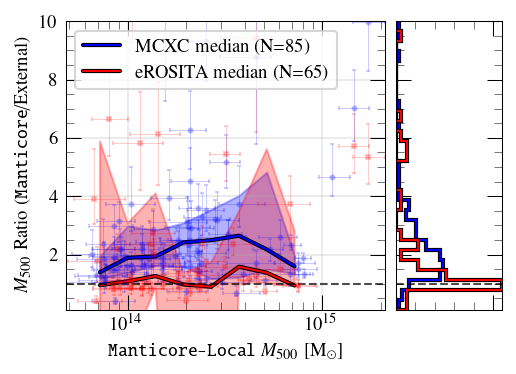


Systematic Offset Analysis:
Total matched objects: 150
Overall median ratio: 1.70
Overall mean ratio: 0.74
Standard deviation: 11.02
25th percentile: 1.08
75th percentile: 2.67
Fraction above 1.0: 80.0%
Fraction above 2.0: 40.7%

MCXC specific:
  Median ratio: 2.00
  Fraction above 1.0: 96.5%

eROSITA specific:
  Median ratio: 1.09
  Fraction above 1.0: 58.5%


In [44]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as pe

# Create figure with custom layout
with plt.style.context(get_mplstyle_path("mnras")):
    fig = plt.figure(figsize=(3.75, 2.5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.05)
    ax_main = fig.add_subplot(gs[0])
    ax_hist = fig.add_subplot(gs[1])
    
    # Create mass bins for median calculation
    mass_bins = np.logspace(13.5, 15.5, 15)
    mass_centers = np.sqrt(mass_bins[:-1] * mass_bins[1:])
    
    # Collect all ratios for histogram
    all_ratios = []
    all_colors = []
    all_labels = []
    
    # MCXC matches
    mcxc_mask = enhanced_manticore['mcxc_matched']
    if np.any(mcxc_mask):
        mcxc_ratio = enhanced_manticore['m500_manticore'][mcxc_mask] / enhanced_manticore['m500_mcxc'][mcxc_mask]
        mcxc_masses = enhanced_manticore['m500_manticore'][mcxc_mask]
        mcxc_p25 = enhanced_manticore['m500_manticore_p25'][mcxc_mask]
        mcxc_p75 = enhanced_manticore['m500_manticore_p75'][mcxc_mask]
        mcxc_external = enhanced_manticore['m500_mcxc'][mcxc_mask]
        
        # Calculate ratio uncertainties
        mcxc_ratio_lower = mcxc_p25 / mcxc_external
        mcxc_ratio_upper = mcxc_p75 / mcxc_external
        mcxc_ratio_lower_err = np.abs(mcxc_ratio - mcxc_ratio_lower)
        mcxc_ratio_upper_err = np.abs(mcxc_ratio_upper - mcxc_ratio)
        
        # Add error bars for both x and y
        mcxc_mass_lower_err = mcxc_masses - mcxc_p25
        mcxc_mass_upper_err = mcxc_p75 - mcxc_masses
        
        # Filter out invalid values
        valid_mask = np.isfinite(mcxc_ratio) & np.isfinite(mcxc_ratio_lower_err) & np.isfinite(mcxc_ratio_upper_err)
        
        ax_main.errorbar(mcxc_masses[valid_mask], mcxc_ratio[valid_mask], 
                    xerr=[mcxc_mass_lower_err[valid_mask], mcxc_mass_upper_err[valid_mask]],
                    yerr=[mcxc_ratio_lower_err[valid_mask], mcxc_ratio_upper_err[valid_mask]],
                    fmt='o', color='blue', alpha=0.2, markersize=2, capsize=1, linewidth=0.5)
        
        # Store for histogram
        all_ratios.extend(mcxc_ratio[valid_mask])
        all_colors.extend(['blue'] * np.sum(valid_mask))
        all_labels.extend(['MCXC'] * np.sum(valid_mask))
        
        # Calculate binned statistics
        mcxc_medians = []
        mcxc_p16 = []
        mcxc_p84 = []
        valid_centers = []
        
        for i in range(len(mass_bins)-1):
            in_bin = (mcxc_masses >= mass_bins[i]) & (mcxc_masses < mass_bins[i+1])
            if np.sum(in_bin) >= 3:
                bin_ratios = mcxc_ratio[in_bin]
                mcxc_medians.append(np.median(bin_ratios))
                mcxc_p16.append(np.percentile(bin_ratios, 16))
                mcxc_p84.append(np.percentile(bin_ratios, 84))
                valid_centers.append(mass_centers[i])
        
        if len(mcxc_medians) > 0:
            mcxc_medians = np.array(mcxc_medians)
            mcxc_p16 = np.array(mcxc_p16)
            mcxc_p84 = np.array(mcxc_p84)
            valid_centers = np.array(valid_centers)
            
            ax_main.fill_between(valid_centers, mcxc_p16, mcxc_p84, 
                            color='blue', alpha=0.3)
            line1 = ax_main.plot(valid_centers, mcxc_medians, color='blue', linewidth=1, 
                    solid_capstyle='round', label=f'MCXC median (N={np.sum(mcxc_mask)})')
            line1[0].set_path_effects([pe.Stroke(linewidth=2, foreground='black'), pe.Normal()])
    
    # eROSITA matches  
    eros_mask = enhanced_manticore['eros_matched']
    if np.any(eros_mask):
        eros_ratio = enhanced_manticore['m500_manticore'][eros_mask] / enhanced_manticore['m500_erosita'][eros_mask]
        eros_masses = enhanced_manticore['m500_manticore'][eros_mask]
        eros_p25 = enhanced_manticore['m500_manticore_p25'][eros_mask]
        eros_p75 = enhanced_manticore['m500_manticore_p75'][eros_mask]
        eros_external = enhanced_manticore['m500_erosita'][eros_mask]
        
        # Calculate ratio uncertainties
        eros_ratio_lower = eros_p25 / eros_external
        eros_ratio_upper = eros_p75 / eros_external
        eros_ratio_lower_err = np.abs(eros_ratio - eros_ratio_lower)
        eros_ratio_upper_err = np.abs(eros_ratio_upper - eros_ratio)
        
        # Add error bars for both x and y
        eros_mass_lower_err = eros_masses - eros_p25
        eros_mass_upper_err = eros_p75 - eros_masses
        
        # Filter out invalid values
        valid_mask = np.isfinite(eros_ratio) & np.isfinite(eros_ratio_lower_err) & np.isfinite(eros_ratio_upper_err)
        
        ax_main.errorbar(eros_masses[valid_mask], eros_ratio[valid_mask],
                    xerr=[eros_mass_lower_err[valid_mask], eros_mass_upper_err[valid_mask]],
                    yerr=[eros_ratio_lower_err[valid_mask], eros_ratio_upper_err[valid_mask]],
                    fmt='s', color='red', alpha=0.2, markersize=2, capsize=1, linewidth=0.5)
        
        # Store for histogram
        all_ratios.extend(eros_ratio[valid_mask])
        all_colors.extend(['red'] * np.sum(valid_mask))
        all_labels.extend(['eROSITA'] * np.sum(valid_mask))
        
        # Calculate binned statistics
        eros_medians = []
        eros_p16 = []
        eros_p84 = []
        valid_centers_eros = []
        
        for i in range(len(mass_bins)-1):
            in_bin = (eros_masses >= mass_bins[i]) & (eros_masses < mass_bins[i+1])
            if np.sum(in_bin) >= 3:
                bin_ratios = eros_ratio[in_bin]
                eros_medians.append(np.median(bin_ratios))
                eros_p16.append(np.percentile(bin_ratios, 16))
                eros_p84.append(np.percentile(bin_ratios, 84))
                valid_centers_eros.append(mass_centers[i])
        
        if len(eros_medians) > 0:
            eros_medians = np.array(eros_medians)
            eros_p16 = np.array(eros_p16)
            eros_p84 = np.array(eros_p84)
            valid_centers_eros = np.array(valid_centers_eros)
            
            ax_main.fill_between(valid_centers_eros, eros_p16, eros_p84,
                            color='red', alpha=0.3)
            line2 = ax_main.plot(valid_centers_eros, eros_medians, color='red', linewidth=1,
                    solid_capstyle='round', label=f'eROSITA median (N={np.sum(eros_mask)})')
            line2[0].set_path_effects([pe.Stroke(linewidth=2, foreground='black'), pe.Normal()])
    
    # Format main plot
    ax_main.set_xlabel(r'$\texttt{Manticore-Local}$ $M_{\mathrm{500}}$ [M$_{\odot}$]')
    ax_main.set_ylabel(r'$M_{\mathrm{500}}$ Ratio ($\texttt{Manticore}$/External)')
    ax_main.set_xscale('log')
    ax_main.grid(True, alpha=0.3)
    ax_main.set_ylim(0.1, 10)
    ax_main.legend()
    ax_main.axhline(1.0, color='black', linestyle='--', alpha=0.7, linewidth=1)
    
    # Create histogram
    all_ratios = np.array(all_ratios)
    all_labels = np.array(all_labels)
    
    # Separate data by catalog
    mcxc_ratios = all_ratios[all_labels == 'MCXC']
    eros_ratios = all_ratios[all_labels == 'eROSITA']
    
    # Plot histograms
    bins = np.linspace(0.1, 10, 30)
    n1, bins1, patches1 = ax_hist.hist(mcxc_ratios, bins=bins, orientation='horizontal', histtype='step',
                                       color='blue', linewidth=1, label=f'MCXC (N={len(mcxc_ratios)})', density=True)
    n2, bins2, patches2 = ax_hist.hist(eros_ratios, bins=bins, orientation='horizontal', histtype='step',
                                       color='red', linewidth=1, label=f'eROSITA (N={len(eros_ratios)})', density=True)
    
    # Add path effects to histogram lines
    for patch in patches1:
        patch.set_path_effects([pe.Stroke(linewidth=2, foreground='black'), pe.Normal()])
    
    for patch in patches2:
        patch.set_path_effects([pe.Stroke(linewidth=2, foreground='black'), pe.Normal()])
    
    # Format histogram
    ax_hist.axhline(1.0, color='black', linestyle='--', alpha=0.7, linewidth=1)
    ax_hist.set_ylim(0.1, 10)
    ax_hist.set_ylabel('')
    ax_hist.set_xticklabels([])
    ax_hist.set_yticklabels([])
    
    plt.tight_layout(pad=0.1)
    plt.savefig("./plots/mass_ratio_external.pdf")
    plt.show()

# Print numerical summary
print("\nSystematic Offset Analysis:")
print("="*50)
if len(all_ratios) > 0:
    print(f"Total matched objects: {len(all_ratios)}")
    print(f"Overall median ratio: {np.median(all_ratios):.2f}")
    print(f"Overall mean ratio: {np.mean(all_ratios):.2f}")
    print(f"Standard deviation: {np.std(all_ratios):.2f}")
    print(f"25th percentile: {np.percentile(all_ratios, 25):.2f}")
    print(f"75th percentile: {np.percentile(all_ratios, 75):.2f}")
    print(f"Fraction above 1.0: {np.sum(all_ratios > 1.0) / len(all_ratios) * 100:.1f}%")
    print(f"Fraction above 2.0: {np.sum(all_ratios > 2.0) / len(all_ratios) * 100:.1f}%")

if len(mcxc_ratios) > 0:
    print(f"\nMCXC specific:")
    print(f"  Median ratio: {np.median(mcxc_ratios):.2f}")
    print(f"  Fraction above 1.0: {np.sum(mcxc_ratios > 1.0) / len(mcxc_ratios) * 100:.1f}%")

if len(eros_ratios) > 0:
    print(f"\neROSITA specific:")
    print(f"  Median ratio: {np.median(eros_ratios):.2f}")
    print(f"  Fraction above 1.0: {np.sum(eros_ratios > 1.0) / len(eros_ratios) * 100:.1f}%")